# Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image # To grab the images and extract useful information

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

np.random.seed(42) # Set random seed

# Data

In [2]:
# Notes: Added train_selected directory in my working directory.
#        Extracted all files from train_selected.zip
# Set the dataset directory
dataset_dir = os.getcwd() + "/train_selected"

# Get the data labels
labels_file = dataset_dir + "/train_selected.csv"
data_labels = pd.read_csv(labels_file)

data_labels.shape
# dataset_dir


(4870, 2)

In [3]:
# Get X files
file_list = [dataset_dir + "/" + str(x) + ".png" for x in list(data_labels["id"])]
# file_list

In [4]:
# Get the labels
# finds column label with value = 'automobile' and assigns value 1 if true or 0 if false
data_labels["class"] = np.where(data_labels['label']=='automobile', 1, 0) 
# counts the number of unique values, sum of 1s and 0s
data_labels["class"].value_counts()
# data_labels


0    4370
1     500
Name: class, dtype: int64

In [5]:
## TO DO ##

# Create a function that will standardise the dataset
# Replace False

def standarise_data(dataset):
    # to standardise pixel data divide by 255
    new_dataset = dataset/255.
     
    return new_dataset


In [6]:
def load_data():
    global X_train, X_test, y_train, y_test, X, y

    # loads the image files into an array, considers the number of pixels and colors.
    X = np.array([np.array(Image.open(fname)) for fname in file_list])
    
    # loads the class into an array
    y = np.array(data_labels["class"])
    
    # sets the split of training ang testing datasets, random_state ensure that every run will provide the same results
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # y_train.shape[0] gets the number of rows
    y_train = y_train.reshape(1, y_train.shape[0])
    y_test = y_test.reshape(1, y_test.shape[0])
    
    # Reshape the training and test examples 
    X_train_f = X_train.reshape(X_train.shape[0], -1).T
    X_test_f = X_test.reshape(X_test.shape[0], -1).T
    
       
    # Standardize data to have feature values between 0 and 1.
    X_train = standarise_data(X_train_f)
    X_test = standarise_data(X_test_f)
    
    X_train = np.squeeze(X_train)
    X_test = np.squeeze(X_test)
    
    print ("Flatten X_train: " + str(X_train.shape))
    print ("Flatten X_test: " + str(X_test.shape))
    
    print ("y_train: " + str(y_train.shape))
    print ("y_test: " + str(y_test.shape))
    
    # print ("Flatten X_train_f: " + str(X_train_f.shape))
    # print ("Flatten X_test_f: " + str(X_test_f.shape))
    
       
    return


In [7]:
load_data()

Flatten X_train: (3072, 3409)
Flatten X_test: (3072, 1461)
y_train: (1, 3409)
y_test: (1, 1461)


# Quick 'normal' ml

You will find the following resources useful:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [8]:
X_train_clf = X_train.T
X_test_clf = X_test.T

y_train_clf = y_train.T.ravel()
y_test_clf = y_test.T.ravel()

print(X_train_clf.shape, X_test_clf.shape, y_train_clf.shape, y_test_clf.shape)

(3409, 3072) (1461, 3072) (3409,) (1461,)


In [9]:
from sklearn.linear_model import LogisticRegressionCV 
import datetime

C_list = np.linspace(0.001, 0.5, 20)
log_reg = LogisticRegressionCV(
    Cs=C_list, cv=10, penalty='l2', scoring='roc_auc', solver='liblinear', tol =1e-4, max_iter=1000, 
    class_weight='balanced', n_jobs=7, verbose=2, refit=True, multi_class='ovr', random_state=42
)

#Fit to our model
start = datetime.datetime.now()
log_reg.fit(X_train_clf, y_train_clf)
end = datetime.datetime.now()
print("Total time taken: {}".format(end - start))

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of  10 | elapsed:  4.8min remaining: 11.3min
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:  7.3min finished


[LibLinear]Total time taken: 0:07:22.430503


In [10]:
#Predict the class
y_test_clf = pd.DataFrame(y_test_clf, columns=["actual"])
y_test_clf["predictions_lr"] = log_reg.predict(X_test_clf)

In [11]:
# Get confusion matrix 
print("Confustion Matrix \n", confusion_matrix(y_test_clf.actual, y_test_clf.predictions_lr))

# Get classification report
print(classification_report(y_test_clf.actual, y_test_clf.predictions_lr))

# Get ROC-AUC
print("ROC-AUC Score \n", roc_auc_score(y_test_clf.actual, y_test_clf.predictions_lr))

# Get accuracy
print("Accuracy Score \n", accuracy_score(y_test_clf.actual, y_test_clf.predictions_lr))

Confustion Matrix 
 [[1154  143]
 [  53  111]]
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1297
           1       0.44      0.68      0.53       164

   micro avg       0.87      0.87      0.87      1461
   macro avg       0.70      0.78      0.73      1461
weighted avg       0.90      0.87      0.88      1461

ROC-AUC Score 
 0.7832874174925251
Accuracy Score 
 0.865845311430527


In [12]:
# A tree based example

from sklearn.ensemble import RandomForestClassifier
import datetime

#Create the model object
rf_class = RandomForestClassifier(
    n_estimators=1000, criterion='entropy', 
    max_depth=15, min_samples_split=3, bootstrap=True, oob_score=True, 
    n_jobs=7, random_state=42, verbose=1, class_weight='balanced' 
)

#Fit to our model
start = datetime.datetime.now()
rf_class.fit(X_train_clf, y_train_clf)
end = datetime.datetime.now()
print("Total time taken: {}".format(end - start))

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    1.6s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    8.4s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:   19.2s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:   33.3s
[Parallel(n_jobs=7)]: Done 1000 out of 1000 | elapsed:   42.4s finished


Total time taken: 0:00:54.318810


In [13]:
#Predict the class
y_test_clf["predictions_rf"] = rf_class.predict(X_test_clf)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:    0.2s
[Parallel(n_jobs=7)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [14]:
# Get confusion matrix 
print("Confustion Matrix \n", confusion_matrix(y_test_clf.actual, y_test_clf.predictions_rf))

# Get classification report
print(classification_report(y_test_clf.actual, y_test_clf.predictions_rf))

# Get ROC-AUC
print("ROC-AUC Score \n", roc_auc_score(y_test_clf.actual, y_test_clf.predictions_rf))

# Get accuracy
print("Accuracy Score \n", accuracy_score(y_test_clf.actual, y_test_clf.predictions_rf))

Confustion Matrix 
 [[1297    0]
 [ 151   13]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.94      1297
           1       1.00      0.08      0.15       164

   micro avg       0.90      0.90      0.90      1461
   macro avg       0.95      0.54      0.55      1461
weighted avg       0.91      0.90      0.86      1461

ROC-AUC Score 
 0.5396341463414634
Accuracy Score 
 0.8966461327857632


# Initialise

In [15]:
## TO DO ##

# Correctly create the layer dimensions as per the brief
# Replace False

# For example layer_dimensions of [5,7,2,1] would be input 5, two hidden layers (7,2) and 1 in output

layer_dimensions = ([X_train.shape[0],10,25,10,1])
#len(layer_dimensions)

In [16]:
## TO DO ##

# Use your knowledge of parameter matrix size to edit the code. 
# Replace False

def initialise_parameters(layer_dimensions):
    """
    Input:
    layer_dimensions -- python (list), one item per layer, number representing size of layer
    
    Output:
    parameters -- python dictionary containing your weight and bias parameters "W1", "b1", ..., "WL", "bL" 
                  with appropriate sizes.
    """
    
    global parameters
    
    np.random.seed(42)
    parameters = {}
    L = len(layer_dimensions)  
    
    for l in range(1, L):
#       parameters['W' + str(l)] = np.random.randn(layer_dimensions[l], layer_dimensions[l-1]) * 0.01 
        parameters['W' + str(l)] = np.random.randn(layer_dimensions[l], layer_dimensions[l-1]) * np.sqrt(2./layer_dimensions[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dimensions[l], 1)) 
        # print(l)
    
    return parameters


# Forward prop
Create a series of functions that will:

Undertake the linear multiplication
Underake the activation of the layer
Store this somewhere for efficient computation of backprop

# Activations
We will need activations

In [17]:
## TO DO ##

# Create a function that will undertake sigmoid activaiton
# Create another function that will undertake relu activation
# Replace False

def sigmoid(Z):
    """    
    Input:
    Z     -- numpy array of any shape
    
    Output:
    A     -- output of sigmoid(z), (should be same shape as Z!)
    cache -- returns Z as well, useful during backpropagation
    """
        
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """    
    Input:
    Z     -- numpy array of any shape
    
    Output:
    A     -- output of relu(z), (should be same shape as Z!)
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = np.maximum(0, Z)
    
    cache = Z 
    
    return A, cache


# Forward Prop

In [18]:
## TO DO ##

# Create a function that will undertake the linear component of forward prop
# Replace False

def linear_forward(A, W, b):
    """
    Input:
    A     -- activations from previous layer
    W     -- weights matrix
    b     -- bias vector

    Output:
    Z     -- the input to activation function 
    cache -- a python dictionary with "A", "W" and "b" for backprop
    """
    
    Z = np.dot(W,A) + b
    
    cache = (A, W, b)
    
    return Z, cache


In [19]:
## TO DO ##

# This function conditionally calls an activation function. 
# Call the correction function above with the correct if statement
# Replace False

def activation_forward(A_prev, W, b, activation):
    """

    Input:
    A_prev     -- activations from previous layer
    W          -- weights matrix
    b          -- bias vector
    activation -- the activation type to be used ("sigmoid" or "relu")

    Output:
    A          -- the output of the activation function, also called the post-activation value 
    cache      -- a python dictionary with two two caches "linear_cache" and "activation_cache" for backprop
    """

    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    ###NOTE###
    # This is where you can put more activation functions for the extension tasks
    
    cache = (linear_cache, activation_cache)

    return A, cache

In [20]:
## TO DO ##

# Architect the forward pass. 
# You will need to firstly determine how many layers there are
# You will then need to pull out the correct parameters we initalised
# Ensure you use the appropriate activation for the middle layers
# Pay special attention to the last layer
# It may help to print out parameters
# Replace False

def total_forward(X, parameters):
    """
    
    Input:
    X            -- raw data
    parameters   -- dictionary of initialised parameters, output from a particular function above.
    
    Returns:
    AL           -- last post-activation value
    caches       -- list of caches from forward activations
    """

    caches = []
    A = X
    L = len(layer_dimensions) - 1
        
    
    # All the layers up until the last (sigmoid) layer
    for l in range(1, L):
  
        A_prev = A 
        A, cache = activation_forward(A_prev, 
                                      parameters['W' + str(l)], 
                                      parameters['b' + str(l)], 
                                      activation = "relu")
        caches.append(cache)
                                                 
    # The last layer - how do we use the sigmoid function?
    
    AL, cache = activation_forward(A, 
                                      parameters['W' + str(L)], 
                                      parameters['b' + str(L)], 
                                      activation = "sigmoid")
    caches.append(cache)
            
    return AL, caches



# Backprop

## Backwards Activation

In [21]:
## TO DO ##

# Differentiate the relu and the sigmoid functions
# Replace False

def relu_backward(dA, cache):
    """
    Input:
    dA      -- post-activation gradient
    cache   -- 'Z' that is used in the backwards prop here.

    Output:
    dZ      -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.copy(dA) # Copying dA first
    
    # What do you set dZ to when Z is what values? 
    # dZ = np.multiply(dA, np.int64(Z > 0))
    dZ = np.where(Z < 0, 0, dZ)
        
    return dZ

def sigmoid_backward(dA, cache):
    
    """
    Input:
    dA      -- post-activation gradient
    cache   -- 'Z' that is used in backprop here

    Returns:
    dZ      -- Gradient of the cost with respect to Z
    """
    Z = cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

In [22]:
# You do not need to do anything here, but notes are included for your interest

def linear_backward(dZ, cache):
    """
    Input:
    dZ        -- Gradient of the cost with respect to 'Z' of current layer
    cache     -- (A_prev, W, b) from forward propag in the current layer, we stored this previously

    Output:
    dA_prev   -- Gradient of the cost w.r.t activation of previous layer
    dW        -- Gradient of the cost w.r.t W of current layer
    db        -- Gradient of the cost w.r.t b of current layer l
    """
    
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [23]:
## TO DO ##

# Use the activation differentiation functions you created above
# Ensure you are putting the right arguments (hint: caches) into the functions
# For the first false, consider what function give back dZ? (what does it require?)
# Replace False

def activation_backward(dA, cache, activation):
    """
    Input:
    dA         -- post-activation gradient for current layer
    cache      -- (linear_cache, activation_cache) stored previously for backprop
    activation -- activation for this layer ("sigmoid" or "relu")
    
    Output:
    dA_prev   -- Gradient of the cost w.r.t activation of previous layer
    dW        -- Gradient of the cost w.r.t W of current layer
    db        -- Gradient of the cost w.r.t b of current layer l
    """
    
    linear_cache, activation_cache = cache

    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache) 
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache) 
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    
    return dA_prev, dW, db

In [24]:
## TO DO ##

# Differentiate the loss function with respect to the last activation layer
# Replace False

def total_backward(AL, Y, caches):
    
    """
    Input:
    AL        -- probability vector, output of the forward propagation (L_model_forward())
    Y         -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches    -- list of caches from relu and sigmoid we kept from forward prop
    
    output:
    grads     -- A dictionary with the gradients named dA+l,dW+l, db+l for each layer
    """
    
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y,AL) - np.divide(1 - Y, 1 - AL))
    # dAL = np.divide(AL - y, np.multiply(AL, 1 - AL))
    # dAL = AL * (1-AL)

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [25]:
## TO DO ##

# Write a function to compute the binary logistic cost function ('cross entropy loss')
# This is on page 51 of the slides from block_1. 
# You may need to transpose elements to make the matrix calculations work
# Replace False

def compute_cost(AL, Y):
    """
    Input:
    AL    -- probability vector for label predictions
    Y     -- truth vector vector

    Output:
    cost  -- cost
    """
    
    m = Y.shape[1]
    
    # Compute loss from aL and y.
    cost_total =  - (np.dot(Y,np.log(AL).T) + np.dot(1- Y,np.log(1-AL).T))
    cost = (1./m) * cost_total 
    
    cost = np.squeeze(cost) # Help with the shape
    # assert(cost.shape == ())
    
    return cost


# Update Parameters

In [26]:
## TO DO ##

# Update each parameter
# Remember what hyperparameter is important for this step?
# You will also find a useful, indexed value in the 'grads' dictionary created in backprop above
# Replace False

def update_parameters(parameters, grads, learning_rate):
    """
    
    Input:
    parameters    -- dictionary with parameters 
    grads         -- dictionary with gradients (which function outputs this?)
    learning_date -- step size to adjust parameters by
    
    Returns:
    parameters    -- dictionary containing your updated parameters , same structure as original parameters dict
    """
    
    L = len(parameters) // 2 ### number of layers

    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
    return parameters


# Put it all together

### Create a function to knit together everything you have done so far and allow for different layer sizes and lengths to be used.

In [27]:
## TO DO ##

# Now stitch it all together. Essentially you will need to call all your functions in turn with the right arguments.
# Initialise parameters
# Undertake forward prop. What is our master function? Consider what we got from initialisation?
# Undertake backwards prop. Again consider our master function for back prop.
# Update parameters.
# Replace False

def total_backward_forward(X, Y, layers_dimensions, 
                           learning_rate, 
                           num_iterations, 
                           print_cost):
    
    """
    Input:
    X                 -- data
    Y                 -- truth vector (1,0)'s
    layers_dimensions -- list of dimensions for each layer of network
    learning_rate     -- step size for gradient descent
    num_iterations    -- number of training iterations to undertake
    print_cost        -- if True, it prints the cost every 100 steps
    
    output:
    parameters        -- parameters learnt by the model. Used to predict
    """

    np.random.seed(42)
    costs = []
    
    # Parameters initialization
    parameters = initialise_parameters(layer_dimensions)
     
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation:
        AL, caches = total_forward(X, parameters)
         
        # Compute cost
        cost = compute_cost(AL, Y)
            
        # Backward propagation.
        grads = total_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters


Cost after iteration 0: 1.405542
Cost after iteration 100: 0.294678
Cost after iteration 200: 0.254238
Cost after iteration 300: 0.228810
Cost after iteration 400: 0.214546


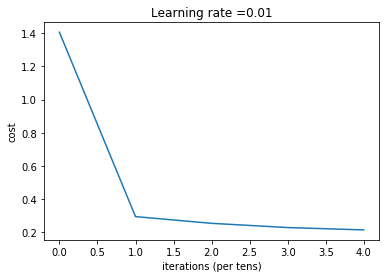

In [28]:
parameters = total_backward_forward(X_train, 
                                    y_train, 
                                    layer_dimensions, 
                                    learning_rate = 0.01,
                                    num_iterations = 500, 
                                    print_cost = True)


In [29]:
#print(parameters)

# Predict (Hold out)

In [30]:
## TO DO ##

# Create your own predict function.
# Note the number of training examples
# Turn the probabilities into 0-1 predictions
# Replace False

def predict(X, y, parameters):
    """ 
    Input:
    X           -- data (test set)
    parameters  -- parameters of the trained model
    
    Output:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[0] # How many training examples?
    print('m: ' + str(m))
    n = len(parameters) // 2
    print('n: ' + str(n))
    p = np.zeros((1,m)) # Initialise probabilities to zero
    
    # Forward propagation
    probas, caches = total_forward(X, parameters)
    print('probas: ' + str(probas))
    
    # convert probas to 0/1 predictions. 
    p = np.where(probas >= 0.5,1,0)
            
    return p, probas

In [31]:
# Create some predictions
predictions, probas = predict(X_test, y_test, parameters)
# print(predictions[0])

m: 3072
n: 4
probas: [[0.2151078  0.02820747 0.01864151 ... 0.00406337 0.03386647 0.07343476]]


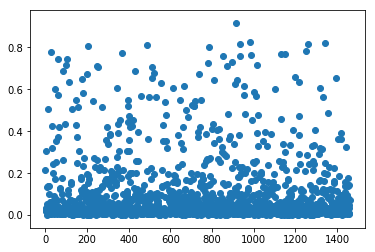

In [32]:
# Make a scatter plot of probabilities. Good check if something is wrong
plt.scatter(range(len(probas[0])), probas)

In [33]:
## Check your prediction value counts
pred_df = pd.DataFrame(predictions[0], columns=["prediction"])
pred_df.prediction.value_counts()

0    1388
1      73
Name: prediction, dtype: int64

In [34]:
# Do a bit of reshaping
predictions_sk = predictions.reshape(len(predictions[0]), 1)
print(predictions_sk.shape)

y_test_sk = y_test.T
print(y_test_sk.shape)

(1461, 1)
(1461, 1)


In [35]:
# Build some sklearn scores

#Get confusion matrix 
print("Confustion Matrix \n", confusion_matrix(list(y_test_sk), list(predictions_sk)))

#Get classification report
print(classification_report(y_test_sk, predictions_sk))

# Accuracy score
print("Accuracy: ", accuracy_score(y_test_sk, predictions_sk))

# ROC_AUC score
print("ROC_AUC: ", roc_auc_score(y_test_sk, probas.T))

Confustion Matrix 
 [[1275   22]
 [ 113   51]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1297
           1       0.70      0.31      0.43       164

   micro avg       0.91      0.91      0.91      1461
   macro avg       0.81      0.65      0.69      1461
weighted avg       0.89      0.91      0.89      1461

Accuracy:  0.9075975359342916
ROC_AUC:  0.8538277826880043
